In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.preprocessing import StandardScaler, MinMaxScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

In [2]:
#import data
df = pd.read_csv('gold_price_data.csv')
gdp = pd.read_csv('gdp_data.csv')

In [3]:
#datetime & make index
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [4]:
#create df_daily with features percent change, diff, lag 30 (min, q10, med, q90, max), lag 360 (min, q10, med, q90, max)
df_daily = df.reindex(pd.date_range(pd.to_datetime('1970-01-01'), pd.to_datetime('2020-03-13'), name='date'))
df_daily['Value'] = df_daily['Value'].interpolate()
df_daily['percent_change'] = df_daily["Value"].pct_change()
df_daily['diff'] = df_daily["Value"].diff()

In [5]:
df_daily = df_daily.dropna()
df_daily.head()

,Value,percent_change,diff
date,,,
1970-01-02,35.198889,-0.000032,-0.001111
1970-01-03,35.197778,-0.000032,-0.001111
1970-01-04,35.196667,-0.000032,-0.001111
1970-01-05,35.195556,-0.000032,-0.001111
1970-01-06,35.194444,-0.000032,-0.001111


In [6]:
#Daily Data Not Statitionairy
y = df_daily['Value']
kpss(y)

C:\Users\dpatteson\AppData\Local\Temp\ipykernel_7228\714723196.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(y)


(15.826440605658474,
 0.01,
 78,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [7]:
#Percentage Data is Stationairy. Ready to Model
y_pct = df_daily['percent_change']
kpss(y_pct)

(0.4243874371184423,
 0.06664334606963696,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [8]:
#ARIMA Model is Too Data Intensive on Daily Data, Downsample to Quarterly Data
df_quarterly = df_daily.resample("Q").mean()
df_quarterly = df_quarterly.drop(columns=['percent_change', 'diff'])
df_quarterly

,Value
date,
1970-03-31,35.150000
1970-06-30,35.248352
1970-09-30,35.795652
1970-12-31,36.793478
1971-03-31,38.141667
...,...
2019-03-31,1303.345556
2019-06-30,1308.873077
2019-09-30,1473.325000


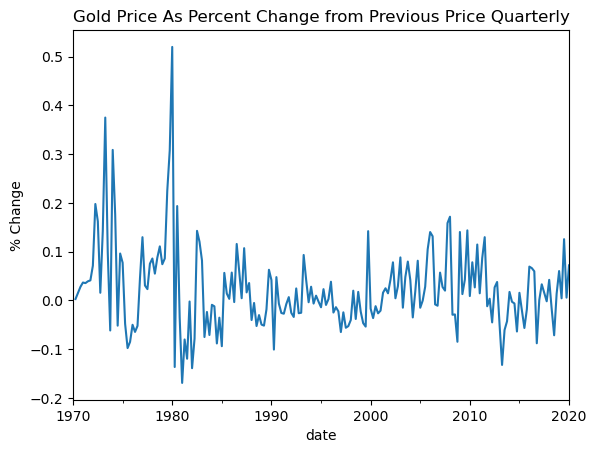

In [9]:
df_quarterly['Percent Change'] = df_quarterly["Value"].pct_change()
df_quarterly['Percent Change'].plot()
plt.title("Gold Price As Percent Change from Previous Price Quarterly")
plt.ylabel('% Change')
plt.show()

In [10]:
#Examine Quarterly
df_quarterly = df_quarterly.dropna()
df_quarterly.head()

,Value,Percent Change
date,,
1970-06-30,35.248352,0.002798
1970-09-30,35.795652,0.015527
1970-12-31,36.793478,0.027876
1971-03-31,38.141667,0.036642
1971-06-30,39.493407,0.035440


In [11]:
#KPSS on Quaterly Data, Quarterly Data Still Stationairy
y_qtr = df_quarterly['Percent Change']
kpss(y_qtr)

C:\Users\dpatteson\AppData\Local\Temp\ipykernel_7228\212519373.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(y_qtr)


(0.24209268345961987,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [12]:
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [13]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                     # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.12f' % (best_cfg, best_score))

In [14]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

In [15]:
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_qtr, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.003508007374
ARIMA(0, 0, 1) MSE=0.003298696718
ARIMA(0, 0, 2) MSE=0.003209183440
ARIMA(1, 0, 0) MSE=0.003180572087
ARIMA(1, 0, 1) MSE=0.003070184827
Best ARIMA(1, 0, 1) MSE=0.003070184827


In [16]:
#Best ARIMA Model
mod = ARIMA(y_qtr, order=(1,0,1))
result = mod.fit()
forecast = result.forecast(4)

In [17]:
#Summary ARIMA Model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Percent Change   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 220.684
Date:                Wed, 03 Jul 2024   AIC                           -433.369
Time:                        14:49:45   BIC                           -420.175
Sample:                    06-30-1970   HQIC                          -428.029
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.015      1.560      0.119      -0.006       0.051
ar.L1          0.7398      0.087      8.532      0.000       0.570       0.910
ma.L1         -0.4858      0.107     -4.535      0.000      -0.696      -0.276
sigma2         0.0064      0.000     17.472      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               215.80
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

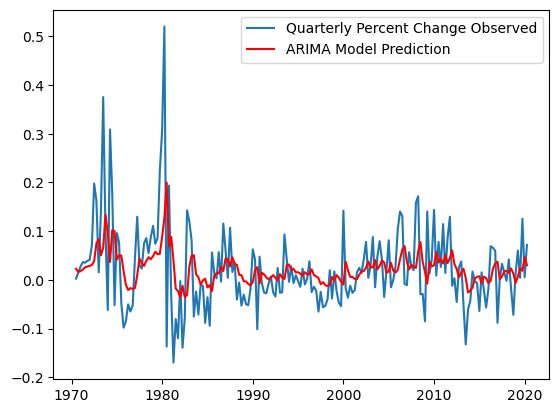

In [18]:
#Visualize ARIMA Results
(line1,) = plt.plot(y_qtr)
(line2,) = plt.plot(result.predict(), color='red')
plt.legend([line1, line2], ["Quarterly Percent Change Observed", "ARIMA Model Prediction"])
plt.show()

In [19]:
#Arima Forecast Next 4 Perecent Changes
forecast

2020-06-30    0.038881
2020-09-30    0.034698
2020-12-31    0.031603
2021-03-31    0.029313
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [20]:
#Polynomial Model on Percent (These turned out very bad)
pct = df_daily[["percent_change"]]
cut3 = int(len(pct)*.8)
pct_train, pct_test = pct[:cut3].to_numpy(), pct[cut3:]
value = df_daily[["Value"]]
value_train, value_test = value[:cut3].to_numpy(), value[cut3:]
for deg in [1, 2, 3 ,4]:
    p, res, _, _, _ = np.polyfit(pct_train.squeeze(), value_train.squeeze(), deg=deg, full=True)
    print("For degree", deg, "Residuals =", res)

For degree 1 Residuals = [6.03114223e+08]
For degree 2 Residuals = [5.92034603e+08]
For degree 3 Residuals = [5.91255809e+08]
For degree 4 Residuals = [5.82716254e+08]


In [21]:
#Polynomial Model on Diff (Slightly better, but still really bad)
diff = df_daily[["diff"]]
cut3 = int(len(diff)*.8)
diff_train, diff_test = diff[:cut3].to_numpy(), diff[cut3:]
value = df_daily[["Value"]]
value_train, value_test = value[:cut3].to_numpy(), value[cut3:]
for deg in [1, 2, 3 ,4]:
    p, res, _, _, _ = np.polyfit(diff_train.squeeze(), value_train.squeeze(), deg=deg, full=True)
    print("For degree", deg, "Residuals =", res)

For degree 1 Residuals = [6.02673651e+08]
For degree 2 Residuals = [5.82465262e+08]
For degree 3 Residuals = [5.81876291e+08]
For degree 4 Residuals = [5.53036346e+08]


In [22]:
#Polynomial Model with the linear values attached to time (Also bad. Polynomial is a bad idea)
value = df_daily[["Value"]]
value_train, value_test = value[:cut3].to_numpy(), value[cut3:]
for deg in [1, 2, 3 ,4]:
    p, res, _, _, _ = np.polyfit(range(len(value_train)), value_train.squeeze(), deg=deg, full=True)
    print("For degree", deg, "Residuals =", res)

For degree 1 Residuals = [3.22478746e+08]
For degree 2 Residuals = [3.20508942e+08]
For degree 3 Residuals = [1.19776532e+08]
For degree 4 Residuals = [68591670.62761922]


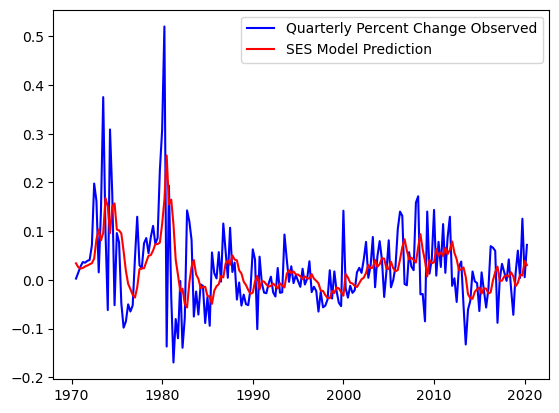

In [23]:
#Simple Exponential Smoothing
fit = SimpleExpSmoothing(y_qtr, initialization_method='estimated').fit()
(line1,) = plt.plot(y_qtr, color='blue')
(line2,) = plt.plot(fit.fittedvalues, color='red')
plt.legend([line1, line2], ["Quarterly Percent Change Observed", "SES Model Prediction"])
plt.show()

In [24]:
error_ses = mean_squared_error(y_qtr, fit.fittedvalues)
print("The MSE of Simple Exponential Smoothing is", error_ses)

The MSE of Simple Exponential Smoothing is 0.006991516126382942


In [25]:
#Forecast for SimpleExpSmoothing
forecast_ses = fit.forecast(4)
forecast_ses

2020-06-30    0.041105
2020-09-30    0.041105
2020-12-31    0.041105
2021-03-31    0.041105
Freq: Q-DEC, dtype: float64

In [26]:
#The ARIMA Model has a better MSE Error .00307 vs. SES .00699, to the ARIMA Model is the best choice. 

In [27]:
#Need last value of dataset to use on the predictions
df_quarterly.tail()

,Value,Percent Change
date,,
2019-03-31,1303.345556,0.060208
2019-06-30,1308.873077,0.004241
2019-09-30,1473.325000,0.125644
2019-12-31,1481.644022,0.005646
2020-03-31,1588.252055,0.071953


In [28]:
#ARIMA Model Forecast Applied to Next Four Prices (Next Year of Gold)
forecast = forecast.to_frame()

In [29]:
forecast = forecast.rename(columns={'predicted_mean': 'percent_change'})
forecast

,percent_change
2020-06-30,0.038881
2020-09-30,0.034698
2020-12-31,0.031603
2021-03-31,0.029313


In [30]:
forecast["Value"] = 0
forecast.loc["2020-03-31"] = [0.071953, 1588.252055]
forecast.index = pd.to_datetime(forecast.index)
forecast = forecast.sort_index()
forecast

,percent_change,Value
2020-03-31,0.071953,1588.252055
2020-06-30,0.038881,0.000000
2020-09-30,0.034698,0.000000
2020-12-31,0.031603,0.000000
2021-03-31,0.029313,0.000000


In [31]:
#Forecasted Gold Values
forecast['Value']['2020-06-30'] = (forecast['percent_change']['2020-06-30']+1)*forecast['Value']["2020-03-31"]
forecast['Value']['2020-09-30'] = (forecast['percent_change']['2020-09-30']+1)*forecast['Value']["2020-06-30"]
forecast['Value']['2020-12-31'] = (forecast['percent_change']['2020-12-31']+1)*forecast['Value']["2020-09-30"]
forecast['Value']['2021-03-31'] = (forecast['percent_change']['2020-03-31']+1)*forecast['Value']["2020-12-31"]
forecast

,percent_change,Value
2020-03-31,0.071953,1588.252055
2020-06-30,0.038881,1650.004954
2020-09-30,0.034698,1707.256057
2020-12-31,0.031603,1761.210062
2021-03-31,0.029313,1887.934409


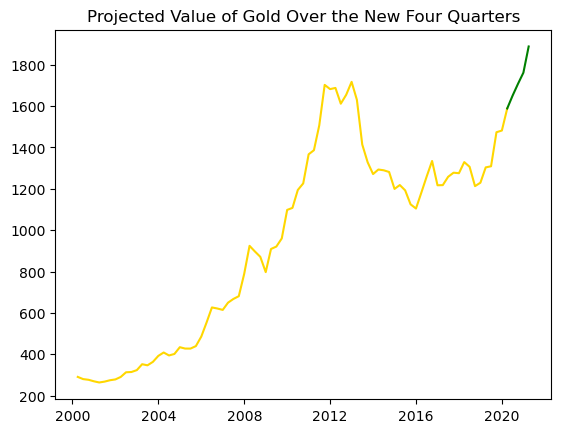

In [32]:
#Visual of the Prices Attached to the Initial Graph
plt.plot(df_quarterly['Value']["01-01-2000":], color="gold")
plt.plot(forecast['Value'], color='green')
plt.title("Projected Value of Gold Over the New Four Quarters")
plt.show()

In [33]:
#GDP vs. Gold Price
gdp.DATE = pd.to_datetime(gdp.DATE)
gdp.set_index('DATE', inplace=True)

gdp['percent_change'] = gdp["GDP"].pct_change()
gdp = gdp.dropna()

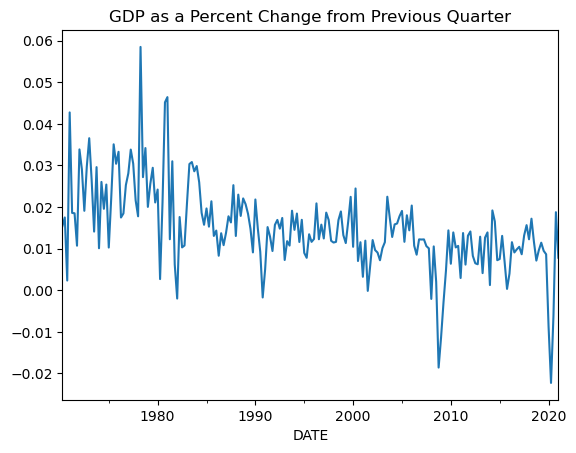

In [34]:
#Plot Percent Change
gdp['percent_change'].plot()
plt.title("GDP as a Percent Change from Previous Quarter")
plt.show()

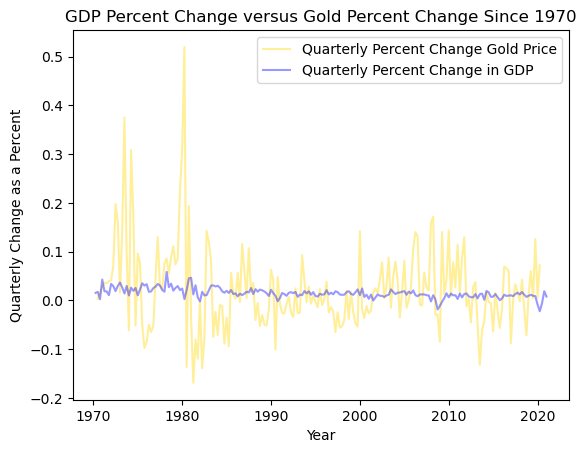

In [35]:
#Comparing Quarterly Gold Price Change & GDP Price Change
(line1,) = plt.plot(df_quarterly['Percent Change'], color='gold', alpha=.4)
(line2,) = plt.plot(gdp['percent_change'], color='blue', alpha=.4)
plt.xlabel("Year")
plt.ylabel("Quarterly Change as a Percent")
plt.legend([line1, line2], ["Quarterly Percent Change Gold Price", "Quarterly Percent Change in GDP"])
plt.title("GDP Percent Change versus Gold Percent Change Since 1970")
plt.show()

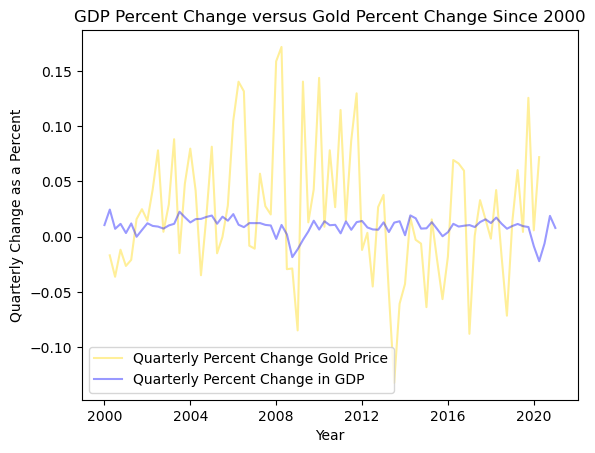

In [36]:
#Comparing Quarterly Gold Price Change & GDP Price Change Since 2000
(line1,) = plt.plot(df_quarterly['Percent Change']['01-01-2000':], color='gold', alpha=.4)
(line2,) = plt.plot(gdp['percent_change']['01-01-2000':], color='blue', alpha=.4)
plt.xlabel("Year")
plt.ylabel("Quarterly Change as a Percent")
plt.legend([line1, line2], ["Quarterly Percent Change Gold Price", "Quarterly Percent Change in GDP"])
plt.title("GDP Percent Change versus Gold Percent Change Since 2000")
plt.show()

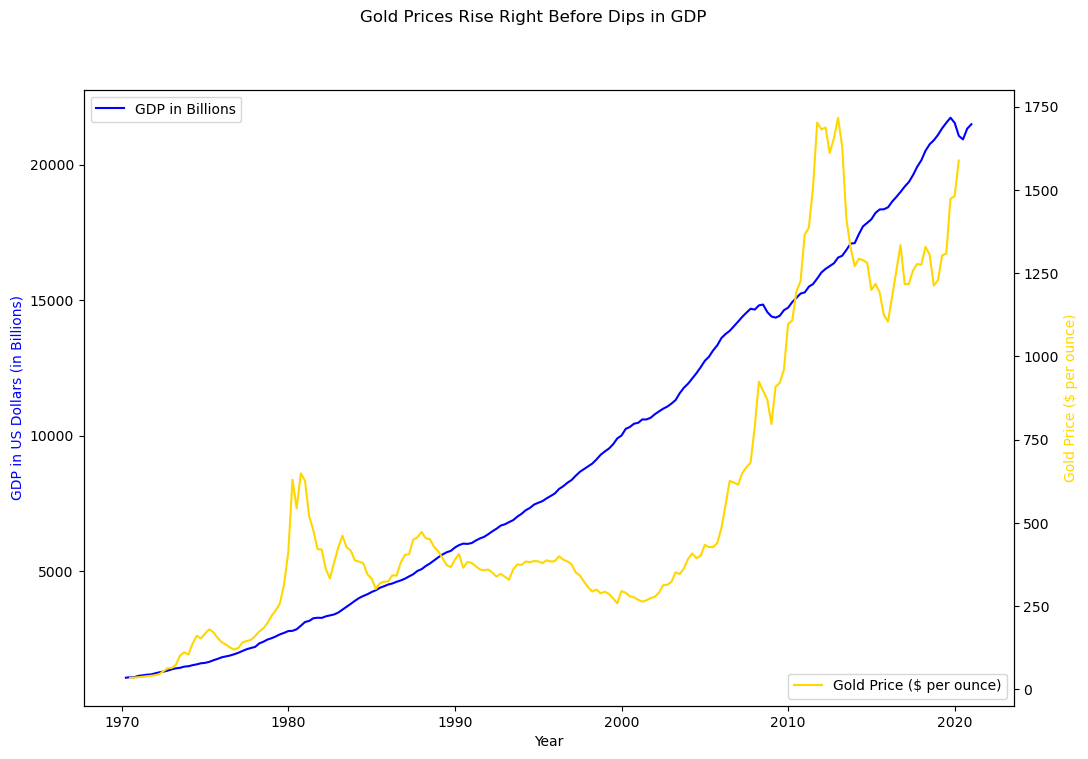

In [37]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
(line1,) = ax1.plot(gdp["GDP"], label="GDP", color='blue')
(line2,) = ax2.plot(df_quarterly['Value'], color='gold')
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP in US Dollars (in Billions)", color='blue')
ax2.set_ylabel("Gold Price ($ per ounce)", color='gold')
fig.suptitle("Gold Prices Rise Right Before Dips in GDP")
ax1.legend([line1], ["GDP in Billions"])
ax2.legend([line2], ["Gold Price ($ per ounce)"], loc='lower right')
plt.show()